# Opis problemu

Celem pracy jest przeprowadzenie predykcji szacowanej ceny komputera z użyciem modelu regresji. 
Model oszacuje jaka powinna być cena komputera w oparciu o wprowadzone dane.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce

## PreProcessing DATA

In [2]:
df = pd.read_csv('C:\\Users\\seba_\\Desktop\\DELL_PULPIT\\Magisterka\\sem3\\MiAML\\laptop_price.csv',
                sep=',',encoding="ISO-8859-1")

## Opis atrybutów

* 1. laptop_id - id laptopa
* 2. Company - Nazwa producenta
* 3. Product - Model produktu
* 4. TypeName - Typ produktu
* 5. Inches - ilość cali ekranu
* 6. ScreenResolution - Rozdzielczość
* 7. Cpu - Rodzaj procesora
* 8. Ram - ilość ramu
* 9. Memory - ilość pamięci 
* 10. Gpu - Rodzaj procesora karty graficznej
* 11. OpSys - System operacyjny
* 12. Weight - waga
* 13. Price_euros - cena laptopa (zmienna docelowa)



In [3]:
df_copy = df.copy()

In [4]:
df_copy.tail()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.0
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.0
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.0
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.0
1302,1320,Asus,X553SA-XX031T (N3050/4GB/500GB/W10),Notebook,15.6,1366x768,Intel Celeron Dual Core N3050 1.6GHz,4GB,500GB HDD,Intel HD Graphics,Windows 10,2.2kg,369.0


In [5]:
df_copy.drop('laptop_ID', axis = 1, inplace = True)

In [6]:
df_copy['Inches'] = df_copy['Inches'].astype(float)

In [7]:
df_copy['ScreenResolution'] = df_copy['ScreenResolution'].str.extract(r"([0-9]+[xX][0-9]+)") 

In [8]:
df_copy['width_pixel'] = df_copy['ScreenResolution'].apply(lambda y: y.split('x')[0] )
df_copy['width_pixel']

0       2560
1       1440
2       1920
3       2880
4       2560
        ... 
1298    1920
1299    3200
1300    1366
1301    1366
1302    1366
Name: width_pixel, Length: 1303, dtype: object

In [9]:
df_copy['height_pixel'] = df_copy['ScreenResolution'].apply(lambda y: y.split('x')[1] )
df_copy['height_pixel']

0       1600
1        900
2       1080
3       1800
4       1600
        ... 
1298    1080
1299    1800
1300     768
1301     768
1302     768
Name: height_pixel, Length: 1303, dtype: object

In [10]:
df_copy['width_pixel'] = df_copy['width_pixel'].astype(int)
df_copy['height_pixel'] = df_copy['height_pixel'].astype(int)

In [11]:
df_copy.drop('ScreenResolution', axis = 1, inplace = True)

In [12]:
df_copy['WeightKG'] = df_copy['Weight'].apply(lambda y: y.split('kg')[0] )

In [13]:
df_copy['WeightKG'] = df_copy['WeightKG'].astype(float)

In [14]:
df_copy.drop('Weight', axis = 1, inplace = True)

In [15]:
df_copy['RamQuantity'] = df_copy['Ram'].apply(lambda y: y.split('GB')[0])

In [16]:
df_copy['RamQuantity'].value_counts()

8     619
4     375
16    200
6      41
12     25
2      22
32     17
24      3
64      1
Name: RamQuantity, dtype: int64

In [17]:
df_copy.drop('Ram', axis = 1, inplace = True)

In [18]:
df_copy['RamQuantity'] = df_copy['RamQuantity'].astype(int)

In [19]:
df_copy['Memory'] = df_copy['Memory'].apply(lambda y: y.split('+')[0] )

In [20]:
df_copy['Memory'] = df_copy['Memory'].str.extract(r"([0-9]+[GB|TB])") 

In [21]:
df_copy['Memory']=df_copy['Memory'].str.replace("[GT]","")

C:\Users\seba_\AppData\Local\Temp\ipykernel_4816\2957101996.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_copy['Memory']=df_copy['Memory'].str.replace("[GT]","")


In [22]:
df_copy['Memory']=df_copy['Memory'].str.replace("0","1")

In [23]:
df_copy['Memory'] = df_copy['Memory'].astype(int)

In [24]:
df_copy["GBorTB"] = df["Memory"].str.extract("(GB|TB)")[0] 

In [25]:
df_copy["GBorTB"].value_counts()

GB    1037
TB     266
Name: GBorTB, dtype: int64

In [26]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1303 non-null   object 
 1   Product       1303 non-null   object 
 2   TypeName      1303 non-null   object 
 3   Inches        1303 non-null   float64
 4   Cpu           1303 non-null   object 
 5   Memory        1303 non-null   int32  
 6   Gpu           1303 non-null   object 
 7   OpSys         1303 non-null   object 
 8   Price_euros   1303 non-null   float64
 9   width_pixel   1303 non-null   int32  
 10  height_pixel  1303 non-null   int32  
 11  WeightKG      1303 non-null   float64
 12  RamQuantity   1303 non-null   int32  
 13  GBorTB        1303 non-null   object 
dtypes: float64(3), int32(4), object(7)
memory usage: 122.3+ KB


In [27]:
df_copy.head()

,Company,Product,TypeName,Inches,Cpu,Memory,Gpu,OpSys,Price_euros,width_pixel,height_pixel,WeightKG,RamQuantity,GBorTB
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 2.3GHz,128,Intel Iris Plus Graphics 640,macOS,1339.69,2560,1600,1.37,8,GB
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5 1.8GHz,128,Intel HD Graphics 6000,macOS,898.94,1440,900,1.34,8,GB
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U 2.5GHz,256,Intel HD Graphics 620,No OS,575.00,1920,1080,1.86,8,GB
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7 2.7GHz,512,AMD Radeon Pro 455,macOS,2537.45,2880,1800,1.83,16,GB
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 3.1GHz,256,Intel Iris Plus Graphics 650,macOS,1803.60,2560,1600,1.37,8,GB


In [28]:
df_copy['GPU_Processor'] = df_copy['Gpu'].apply(lambda y: y.split(' ')[0] )

In [29]:
df_copy['GPU_Processor'].value_counts()

Intel     722
Nvidia    400
AMD       180
ARM         1
Name: GPU_Processor, dtype: int64

In [30]:
df_copy['CPU_Processor'] = df_copy['Cpu'].apply(lambda y: y.split(' ')[0] )

In [31]:
df_copy['CPU_Processor'].value_counts()

Intel      1240
AMD          62
Samsung       1
Name: CPU_Processor, dtype: int64

In [32]:
df_copy.drop('Cpu', axis = 1, inplace = True)

In [33]:
df_copy.drop('Gpu', axis = 1, inplace = True)

In [34]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        1303 non-null   object 
 1   Product        1303 non-null   object 
 2   TypeName       1303 non-null   object 
 3   Inches         1303 non-null   float64
 4   Memory         1303 non-null   int32  
 5   OpSys          1303 non-null   object 
 6   Price_euros    1303 non-null   float64
 7   width_pixel    1303 non-null   int32  
 8   height_pixel   1303 non-null   int32  
 9   WeightKG       1303 non-null   float64
 10  RamQuantity    1303 non-null   int32  
 11  GBorTB         1303 non-null   object 
 12  GPU_Processor  1303 non-null   object 
 13  CPU_Processor  1303 non-null   object 
dtypes: float64(3), int32(4), object(7)
memory usage: 122.3+ KB


### Statystyka - Start

<AxesSubplot:>

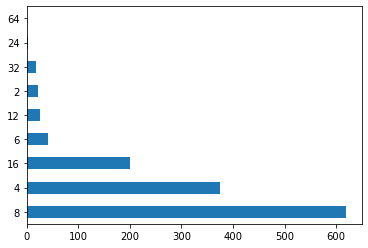

In [35]:
df_copy['RamQuantity'].value_counts().plot(kind='barh')

<AxesSubplot:>

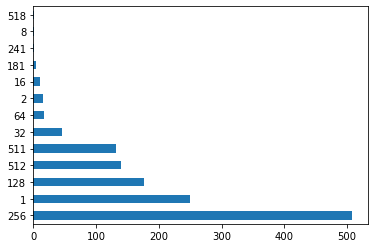

In [36]:
df_copy['Memory'].value_counts().plot(kind='barh')

In [37]:
df_copy.head()

,Company,Product,TypeName,Inches,Memory,OpSys,Price_euros,width_pixel,height_pixel,WeightKG,RamQuantity,GBorTB,GPU_Processor,CPU_Processor
0,Apple,MacBook Pro,Ultrabook,13.3,128,macOS,1339.69,2560,1600,1.37,8,GB,Intel,Intel
1,Apple,Macbook Air,Ultrabook,13.3,128,macOS,898.94,1440,900,1.34,8,GB,Intel,Intel
2,HP,250 G6,Notebook,15.6,256,No OS,575.00,1920,1080,1.86,8,GB,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,15.4,512,macOS,2537.45,2880,1800,1.83,16,GB,AMD,Intel
4,Apple,MacBook Pro,Ultrabook,13.3,256,macOS,1803.60,2560,1600,1.37,8,GB,Intel,Intel


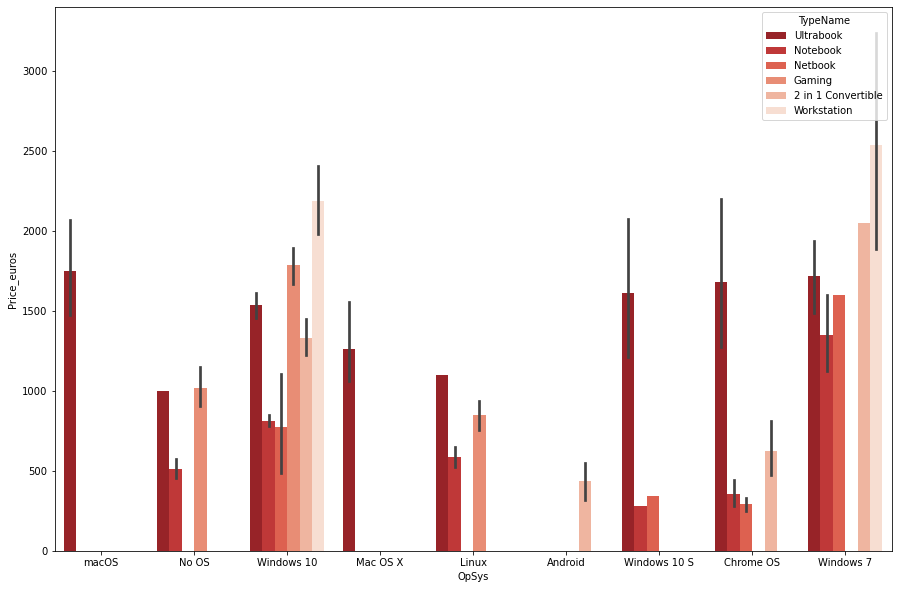

In [38]:

f, ax = plt.subplots(1,1, figsize=(15,10))
ax = sns.barplot(x = 'OpSys', y = 'Price_euros',
                 hue='TypeName', data=df_copy, palette='Reds_r')

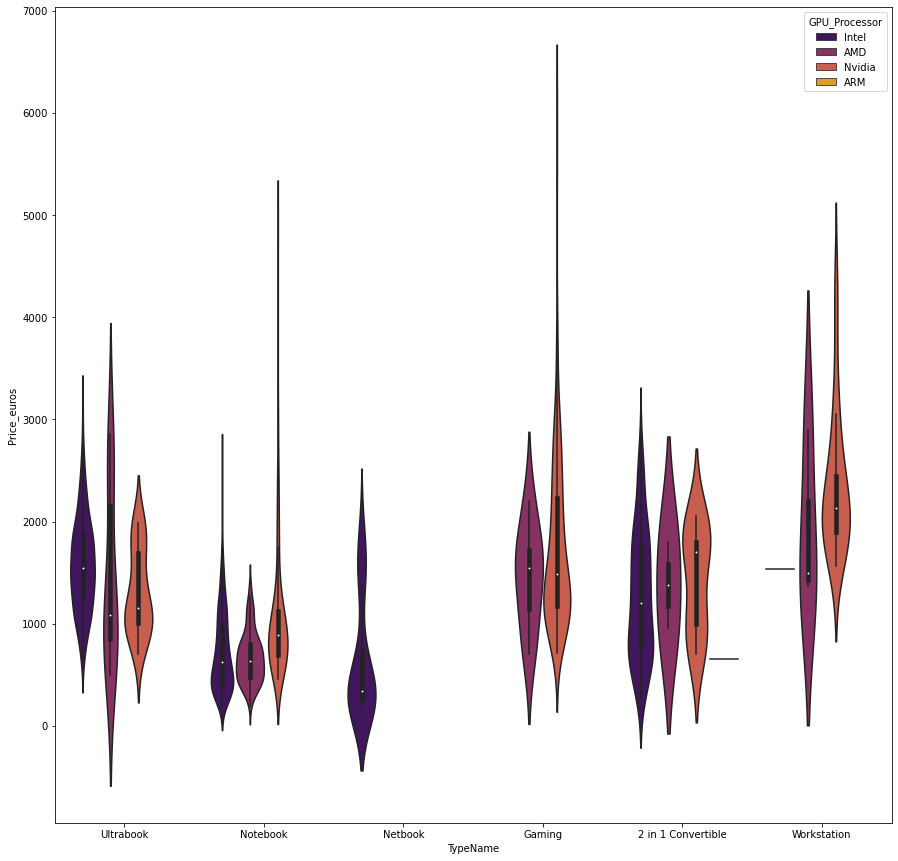

In [39]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.violinplot(x = 'TypeName', y = 'Price_euros', data=df_copy,
                 orient='v', hue='GPU_Processor', palette='inferno')

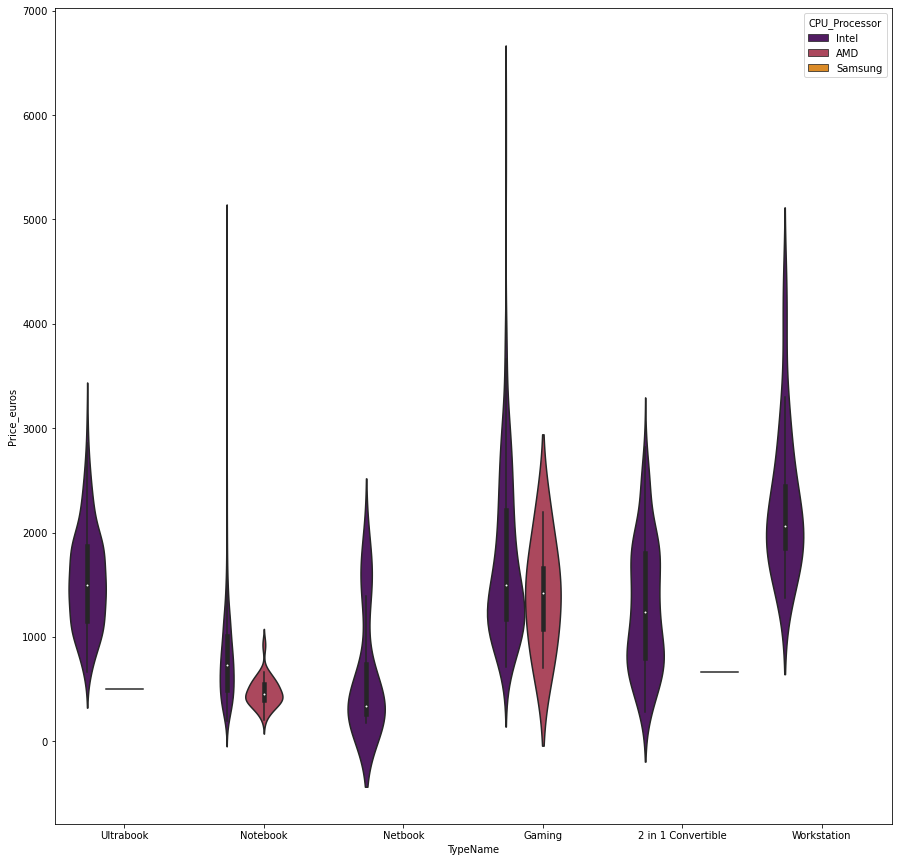

In [40]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.violinplot(x = 'TypeName', y = 'Price_euros', data=df_copy,
                 orient='v', hue='CPU_Processor', palette='inferno')

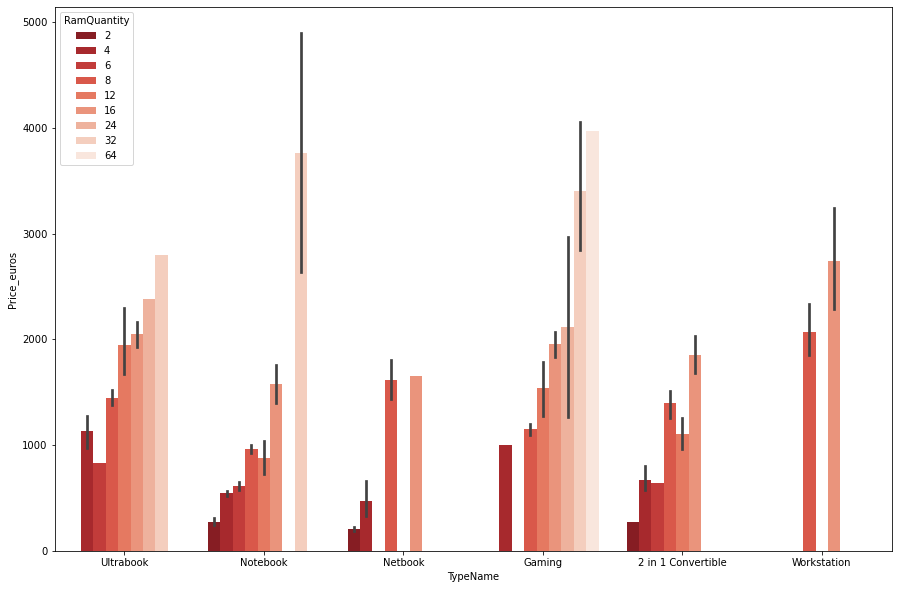

In [41]:
f, ax = plt.subplots(1,1, figsize=(15,10))
ax = sns.barplot(x = 'TypeName', y = 'Price_euros',
                 hue='RamQuantity', data=df_copy, palette='Reds_r')

C:\AnacondaNavigator\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


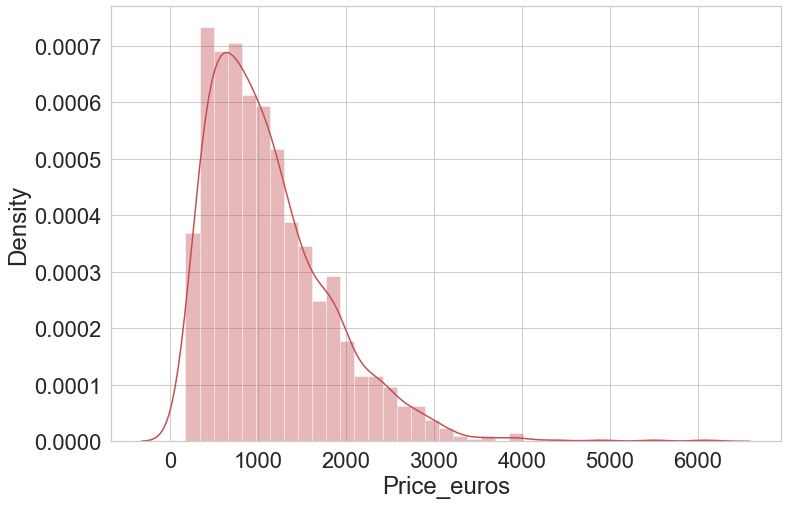

In [137]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.distplot((df_copy['Price_euros']), kde = True, color = 'r' )

C:\AnacondaNavigator\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


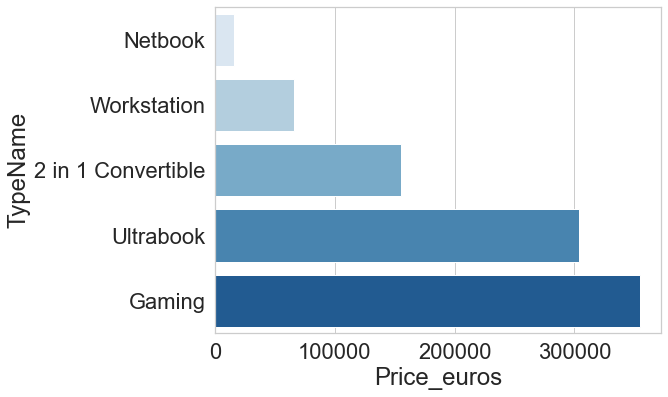

In [138]:
charges = df_copy['Price_euros'].groupby(df_copy.TypeName).sum().sort_values(ascending = True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(charges.head(), charges.head().index, palette='Blues')

C:\AnacondaNavigator\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\AnacondaNavigator\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\AnacondaNavigator\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


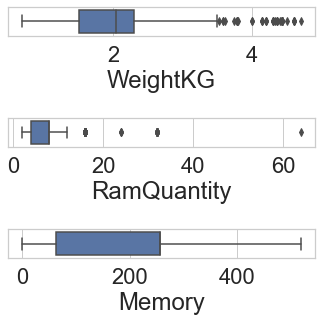

In [139]:
fig, axs = plt.subplots(3, figsize = (5,5))
plt1 = sns.boxplot(df_copy['WeightKG'], ax = axs[0])
plt2 = sns.boxplot(df_copy['RamQuantity'], ax = axs[1])
plt3 = sns.boxplot(df_copy['Memory'], ax = axs[2])
plt.tight_layout()

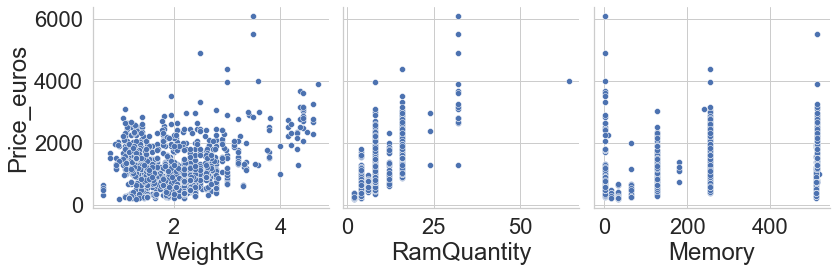

In [140]:
sns.pairplot(df_copy, x_vars=['WeightKG', 'RamQuantity', 'Memory'], y_vars='Price_euros', height=4, aspect=1, kind='scatter')
plt.show()

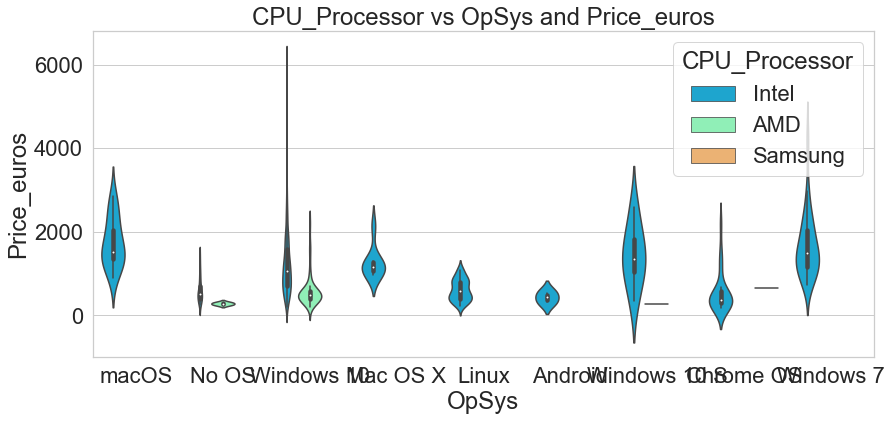

In [141]:
plt.figure(figsize=(14,6))
sns.violinplot(x='OpSys', y='Price_euros',hue='CPU_Processor',data=df_copy,palette='rainbow',split=False)
plt.title('CPU_Processor vs OpSys and Price_euros');

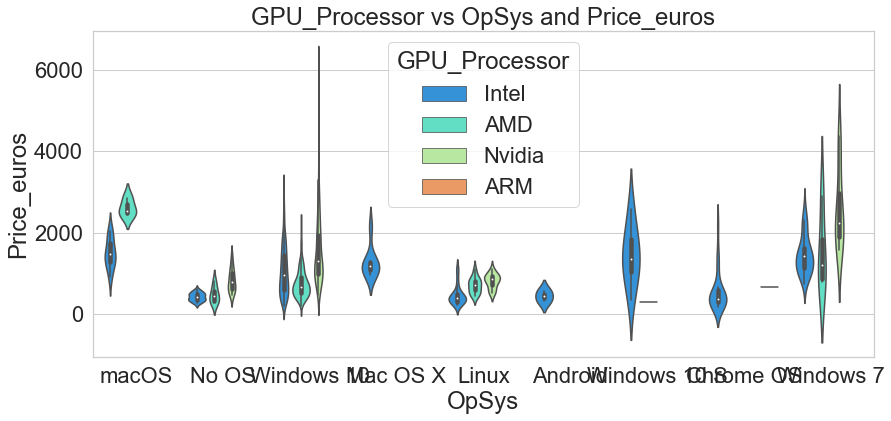

In [142]:
plt.figure(figsize=(14,6))
sns.violinplot(x='OpSys', y='Price_euros',hue='GPU_Processor',data=df_copy,palette='rainbow',split=False)
plt.title('GPU_Processor vs OpSys and Price_euros');

### Statystyka - koniec

### MODEL

In [143]:
df_model = df_copy.copy()

In [144]:
df_model.drop('Product', axis = 1, inplace = True)

In [145]:
from sklearn.preprocessing import LabelEncoder

In [146]:
obj_cols = ['Company', 'TypeName', 'OpSys','GBorTB','GPU_Processor','CPU_Processor']

lb = LabelEncoder()

for i in obj_cols:
    print(f"Value Counts of columns:{i}")
    print(df_model.loc[:,i].value_counts())
    df_model[i] = lb.fit_transform(df_model[i])
    print('The classes which labeled from 0 are:',lb.classes_, end="\n")

Value Counts of columns:Company
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: Company, dtype: int64
The classes which labeled from 0 are: ['Acer' 'Apple' 'Asus' 'Chuwi' 'Dell' 'Fujitsu' 'Google' 'HP' 'Huawei'
 'LG' 'Lenovo' 'MSI' 'Mediacom' 'Microsoft' 'Razer' 'Samsung' 'Toshiba'
 'Vero' 'Xiaomi']
Value Counts of columns:TypeName
Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: TypeName, dtype: int64
The classes which labeled from 0 are: ['2 in 1 Convertible' 'Gaming' 'Netbook' 'Notebook' 'Ultrabook'
 'Workstation']
Value Counts of columns:OpSys
Windows 10      1072
No OS             66
Linux     

In [147]:
df_model.head()

,Company,TypeName,Inches,Memory,OpSys,Price_euros,width_pixel,height_pixel,WeightKG,RamQuantity,GBorTB,GPU_Processor,CPU_Processor
0,1,4,13.3,128,8,1339.69,2560,1600,1.37,8,0,2,1
1,1,4,13.3,128,8,898.94,1440,900,1.34,8,0,2,1
2,7,3,15.6,256,4,575.00,1920,1080,1.86,8,0,2,1
3,1,4,15.4,512,8,2537.45,2880,1800,1.83,16,0,0,1
4,1,4,13.3,256,8,1803.60,2560,1600,1.37,8,0,2,1


In [148]:
df_model_polynominal = df_model.copy()

In [149]:
df_model.describe()

,Company,TypeName,Inches,Memory,OpSys,Price_euros,width_pixel,height_pixel,WeightKG,RamQuantity,GBorTB,GPU_Processor,CPU_Processor
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,6.442824,2.582502,15.017191,227.534919,4.808903,1123.686992,1894.784344,1070.830391,2.038734,8.382195,0.204144,2.029931,0.953185
std,4.084128,1.245231,1.426304,176.391005,1.035253,699.009043,494.641028,284.519410,0.665475,5.084665,0.403230,0.927409,0.214927
min,0.000000,0.000000,10.100000,1.000000,0.000000,174.000000,1366.000000,768.000000,0.690000,2.000000,0.000000,0.000000,0.000000
25%,4.000000,1.500000,14.000000,64.000000,5.000000,599.000000,1600.000000,900.000000,1.500000,4.000000,0.000000,2.000000,1.000000
50%,7.000000,3.000000,15.600000,256.000000,5.000000,977.000000,1920.000000,1080.000000,2.040000,8.000000,0.000000,2.000000,1.000000
75%,10.000000,3.000000,15.600000,256.000000,5.000000,1487.880000,1920.000000,1080.000000,2.300000,8.000000,0.000000,3.000000,1.000000
max,18.000000,5.000000,18.400000,518.000000,8.000000,6099.000000,3840.000000,2160.000000,4.700000,64.000000,1.000000,3.000000,2.000000


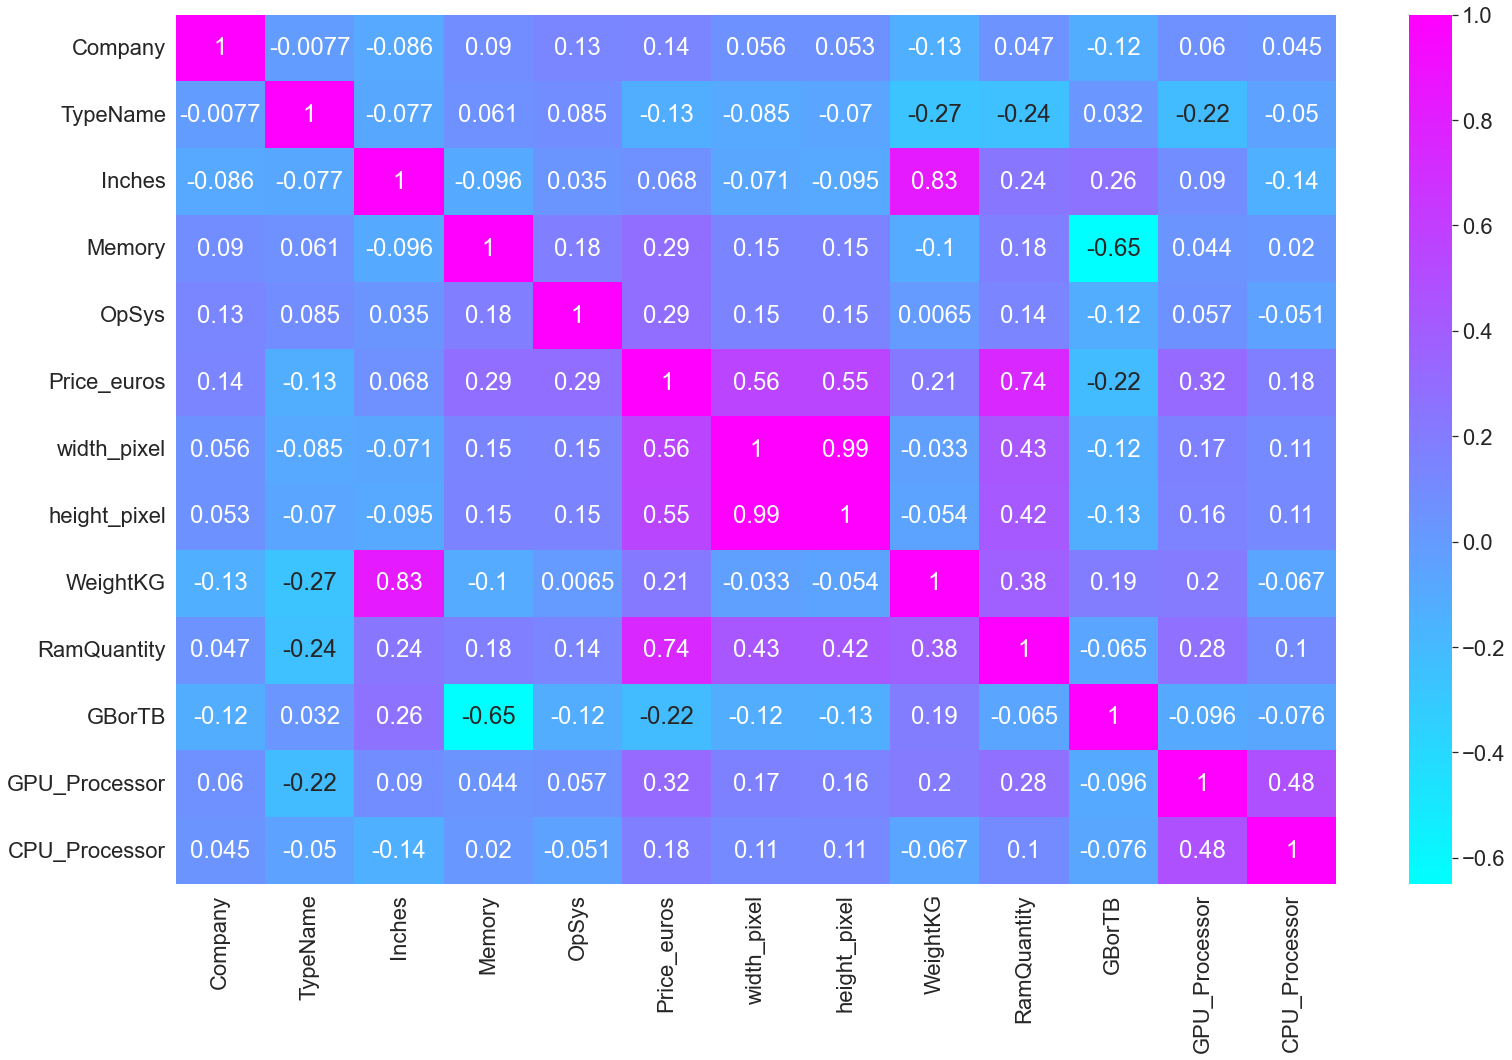

In [182]:
f, ax = plt.subplots(1, 1, figsize=(26,16))
ax = sns.heatmap(df_model.corr(), annot=True, cmap='cool')

## Linear Regression

In [151]:
from sklearn.model_selection import train_test_split as holdout
from sklearn.linear_model import LinearRegression
from sklearn import metrics

x = df_model.drop(['Price_euros'], axis = 1)
y = df['Price_euros']

x_train, x_test, y_train, y_test = holdout(x, y, test_size=0.2, random_state=0)
Lin_reg = LinearRegression()
Lin_reg.fit(x_train, y_train)

y_train_pred = Lin_reg.predict(x_train)
y_test_pred = Lin_reg.predict(x_test)
print(Lin_reg.intercept_)
print(Lin_reg.coef_)
print(Lin_reg.score(x_test, y_test))

-260.58460146591506
[  9.85437782  37.16263351 -84.81679356   0.32511994  97.87551616
   0.2345155    0.22032195 191.11498006  74.49592597 -92.26468593
  57.21766539 163.99233905]
0.6522389960380757


In [152]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 323.73585279273436
Mean Squared Error: 204705.94750935398
Root Mean Squared Error: 452.4444137232263


In [153]:
y_test_pred = Lin_reg.predict(x_test)
##Comparing the actual output values with the predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
linear_df=df
df


,Actual,Predicted
580,389.00,823.247699
1017,2968.00,2696.397597
761,1859.00,1823.977433
686,612.61,559.261166
186,2397.00,2520.729754
...,...,...
1176,825.00,927.509735
549,1729.00,1225.075436
922,1149.00,1688.665512
399,2625.00,1800.558312


## Ridge Regression

In [154]:
from sklearn.linear_model import Ridge
Ridge = Ridge(alpha=0.5)
Ridge.fit(x_train, y_train)

y_train_pred = Ridge.predict(x_train)
y_test_pred = Ridge.predict(x_test)

print(Ridge.intercept_)
print(Ridge.coef_)
print(Ridge.score(x_test, y_test))

-261.31454623831314
[  9.84791991  37.07139282 -84.50057224   0.32563827  97.78599187
   0.23370728   0.22166703 190.0649643   74.5196722  -91.85238428
  57.50596715 161.82420302]
0.6522846884862191


In [155]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 323.7027544102333
Mean Squared Error: 204679.0511184859
Root Mean Squared Error: 452.4146893266021


In [156]:
y_test_pred = Ridge.predict(x_test)
##Comparing the actual output values with the predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
ridge_df=df
df

,Actual,Predicted
580,389.00,823.044431
1017,2968.00,2696.797169
761,1859.00,1823.944822
686,612.61,558.865405
186,2397.00,2521.166551
...,...,...
1176,825.00,927.129007
549,1729.00,1225.167816
922,1149.00,1688.389964
399,2625.00,1801.260878


## Lasso Regression

In [157]:
from sklearn.linear_model import Lasso
Lasso = Lasso(alpha=0.2, fit_intercept=True, normalize=False, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
Lasso.fit(x_train, y_train)

y_train_pred = Lasso.predict(x_train)
y_test_pred = Lasso.predict(x_test)

print(Lasso.intercept_)
print(Lasso.coef_)
print(Lasso.score(x_test, y_test))

-262.8189730123088
[  9.8353587   36.77123809 -83.98408764   0.32807687  97.60093439
   0.23218324   0.22439478 188.42912511  74.54272509 -90.27376914
  57.74558239 158.9227583 ]
0.6523511432684732


C:\AnacondaNavigator\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [158]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 323.6661496654363
Mean Squared Error: 204639.93319263202
Root Mean Squared Error: 452.37145488263513


In [159]:
y_test_pred = Lasso.predict(x_test)
##Comparing the actual output values with the predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
lasso_df=df
df

,Actual,Predicted
580,389.00,822.190191
1017,2968.00,2697.454888
761,1859.00,1823.380747
686,612.61,558.911767
186,2397.00,2521.947913
...,...,...
1176,825.00,926.835989
549,1729.00,1225.544458
922,1149.00,1687.686658
399,2625.00,1802.441335


## Random Forest Regressor

In [160]:
from sklearn.ensemble import RandomForestRegressor as rfr

x = df_model.drop(['Price_euros'], axis=1)
y = df_model.Price_euros

Rfr = rfr(n_estimators = 100, criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
Rfr.fit(x_train,y_train)
x_train_pred = Rfr.predict(x_train)
x_test_pred = Rfr.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % 
      (metrics.mean_squared_error(x_train_pred, y_train),
       metrics.mean_squared_error(x_test_pred, y_test)))
print('R2 train data: %.3f, R2 test data: %.3f' % 
      (metrics.r2_score(x_train_pred, y_train),
       metrics.r2_score(x_test_pred, y_test)))

print(Rfr.score(x_test, y_test))

C:\AnacondaNavigator\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


MSE train data: 16984.915, MSE test data: 119760.338
R2 train data: 0.959, R2 test data: 0.715
0.7965473115692037


In [161]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 323.6661496654363
Mean Squared Error: 204639.93319263202
Root Mean Squared Error: 452.37145488263513


In [162]:
y_test_pred = Rfr.predict(x_test)
##Comparing the actual output values with the predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
random_df=df
df

,Actual,Predicted
580,389.00,266.415440
1017,2968.00,2378.016483
761,1859.00,1790.161200
686,612.61,435.531800
186,2397.00,2049.201100
...,...,...
1176,825.00,803.299400
549,1729.00,1526.974867
922,1149.00,1248.308467
399,2625.00,2513.197900


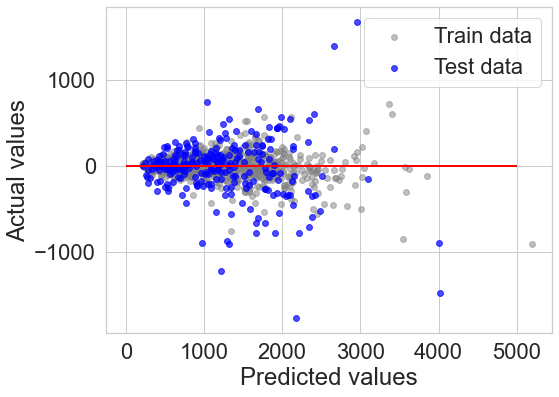

In [163]:
plt.figure(figsize=(8,6))

plt.scatter(x_train_pred, x_train_pred - y_train,
          c = 'gray', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(x_test_pred, x_test_pred - y_test,
          c = 'blue', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend(loc = 'upper right')
plt.hlines(y = 0, xmin = 0, xmax = 5000, lw = 2, color = 'red')

Feature importance ranking


1.WeightKG(0.587188)
2.height_pixel(0.136160)
3.TypeName(0.070374)
4.Company(0.045321)
5.Memory(0.038646)
6.Inches(0.029954)
7.width_pixel(0.023395)
8.Price_euros(0.021690)
9.OpSys(0.020411)
10.RamQuantity(0.013492)
11.GBorTB(0.012225)
12.GPU_Processor(0.001144)


<BarContainer object of 12 artists>

<Figure size 432x288 with 0 Axes>

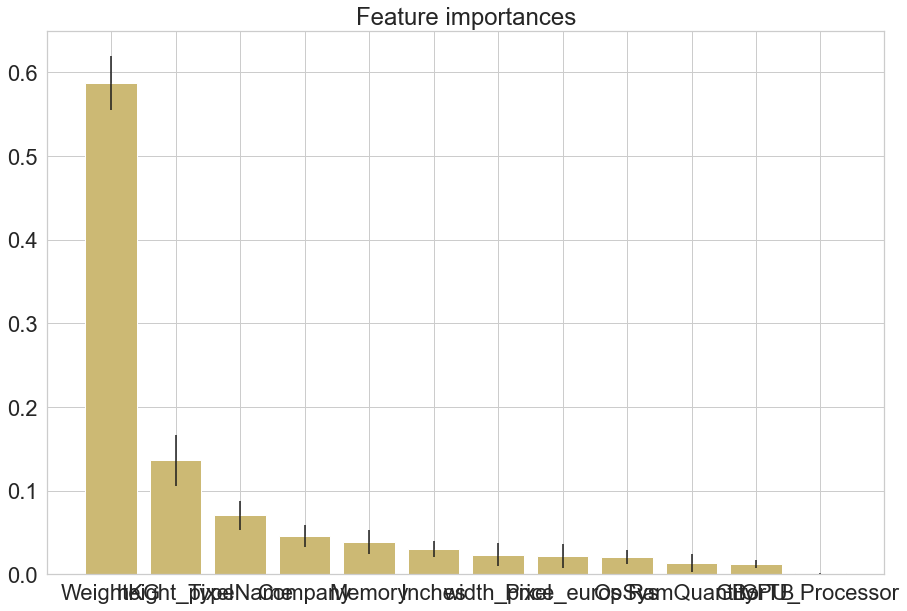

In [164]:

print('Feature importance ranking\n\n')
importances = Rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rfr.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
variables = ['Company', 'TypeName', 'Inches', 'Memory','OpSys', 
             'Price_euros','width_pixel','height_pixel','WeightKG','RamQuantity','GBorTB','GPU_Processor','CPU_Processor']
importance_list = []
for f in range(x.shape[1]):
    variable = variables[indices[f]]
    importance_list.append(variable)
    print("%d.%s(%f)" % (f + 1, variable, importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(importance_list, importances[indices],
       color="y", yerr=std[indices], align="center")

## Polynomial Regression

In [165]:
from sklearn.preprocessing import PolynomialFeatures

x = df_model_polynominal.drop(['Price_euros','GPU_Processor', 'GBorTB'], axis = 1)
y = df_model_polynominal.Price_euros

pol = PolynomialFeatures (degree = 2)
x_pol = pol.fit_transform(x)
x_train, x_test, y_train, y_test = holdout(x_pol, y, test_size=0.2, random_state=0)
Pol_reg = LinearRegression()
Pol_reg.fit(x_train, y_train)
y_train_pred = Pol_reg.predict(x_train)
y_test_pred = Pol_reg.predict(x_test)
print(Pol_reg.intercept_)
print(Pol_reg.coef_)
print(Pol_reg.score(x_test, y_test))

-15338360898.870577
[ 1.53383619e+10  5.98617591e+00 -2.63500913e+01  4.57497801e+01
  4.48230733e+00 -7.91201216e+01  1.54208476e+02 -2.76047509e+02
 -9.10624944e+02 -5.41520031e+01  3.42110073e+04 -2.34275126e-01
 -7.87601157e+00 -1.56742370e+00  3.86591049e-02  1.15819684e+00
  5.23350803e-01 -9.19592219e-01  2.95382535e+00  5.80037940e-01
  2.03657747e+01  8.92206885e+01 -4.37025574e+01  3.66018116e-02
  3.69233790e-01  1.78789680e+00 -3.08944386e+00  1.08241466e+02
 -8.02638786e+00  1.15407195e+02  1.25857509e+01 -1.99095047e-01
 -4.38572169e+01 -1.65701242e+00  3.04232316e+00 -4.87583892e+01
  7.60936011e+00 -7.43549880e+01 -2.27241827e-03  1.47407210e-01
 -8.19124344e-03  1.34811874e-02 -2.80530482e-01  1.38940307e-03
  7.22764219e-01  5.32855737e+00  6.90972875e-01 -7.75121944e-01
  1.31341161e+02 -8.69876606e+00  5.84748905e+01  3.96534517e-02
 -1.17551335e-01 -6.97792736e+00  9.17208447e-02 -1.56198270e+02
  8.33647129e-02  1.18819652e+01 -1.18538257e-01  2.77776761e+02
  2.9

In [166]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 312.56028319903265
Mean Squared Error: 203288.35285047948
Root Mean Squared Error: 450.87509672910465


In [167]:
y_test_pred = Pol_reg.predict(x_test)
##Comparing the actual output values with the predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
polynomial_df=df
df

,Actual,Predicted
580,389.00,649.694185
1017,2968.00,3053.124649
761,1859.00,1560.969362
686,612.61,606.485546
186,2397.00,1715.127831
...,...,...
1176,825.00,830.880342
549,1729.00,1031.775137
922,1149.00,1904.215136
399,2625.00,1847.635597


# Wnioski

do przeprowadzenia badania wybrano kilka typów regresji:
    1. Linear regression 
    2. Ridge regression 
    3. Lasso regression 
    4. Random Forest regression 
    5. Polynomial regression 
  

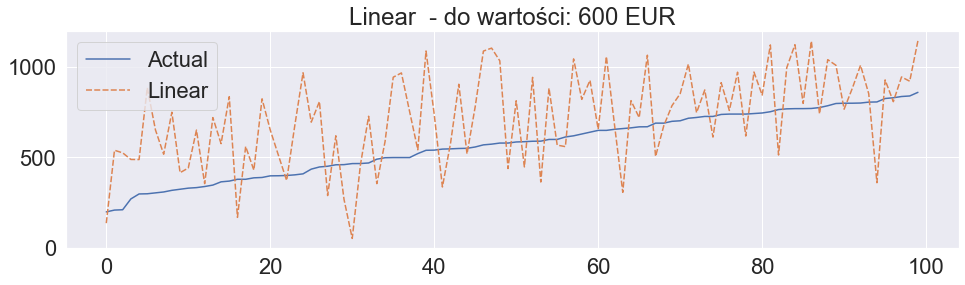

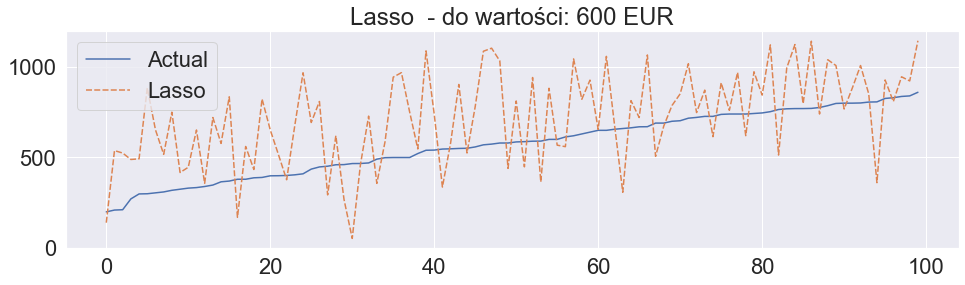

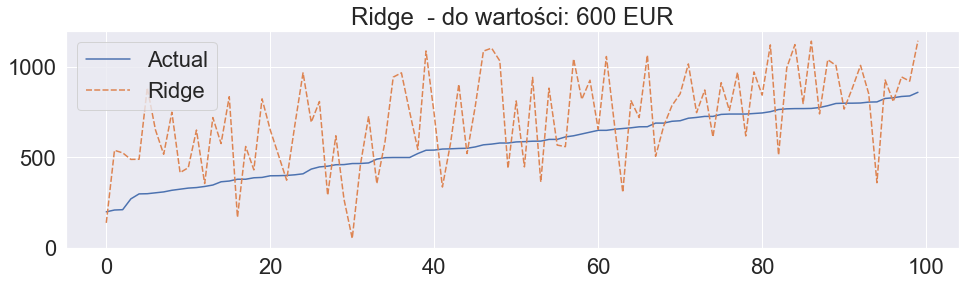

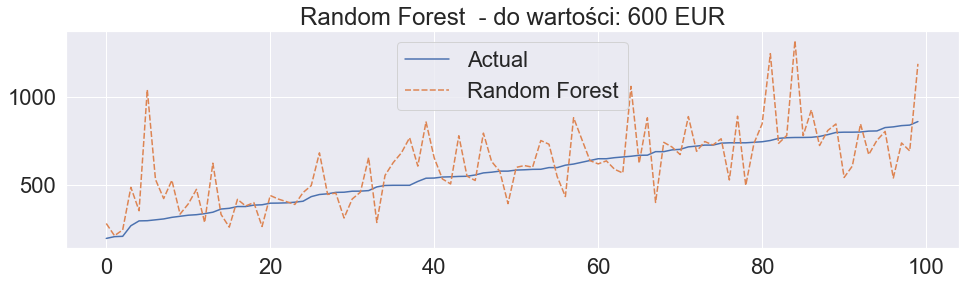

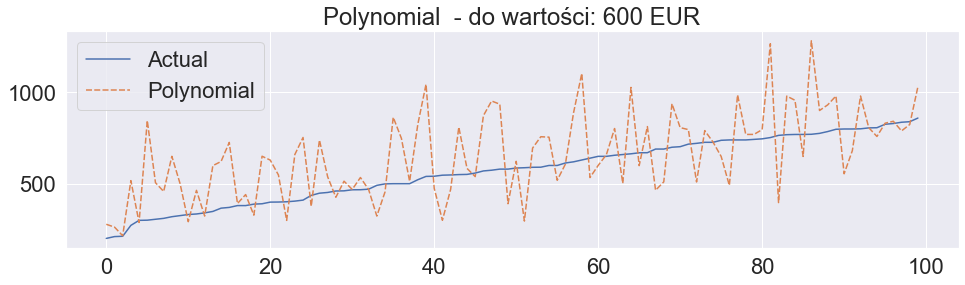

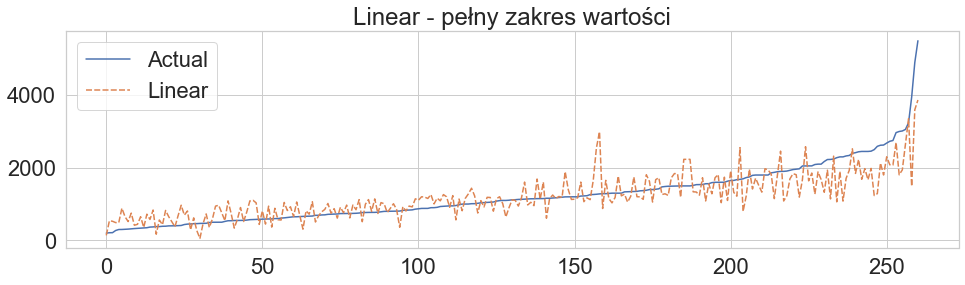

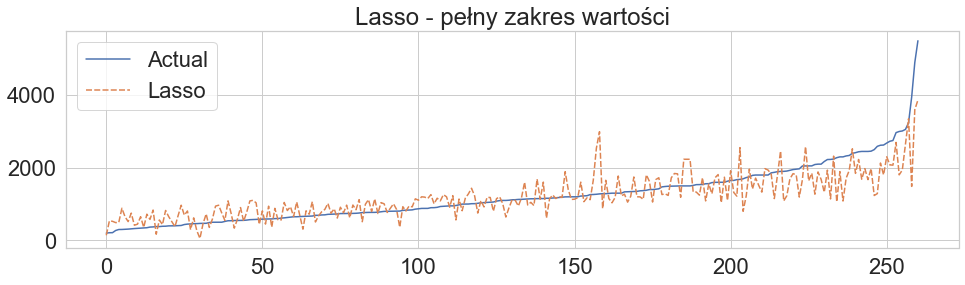

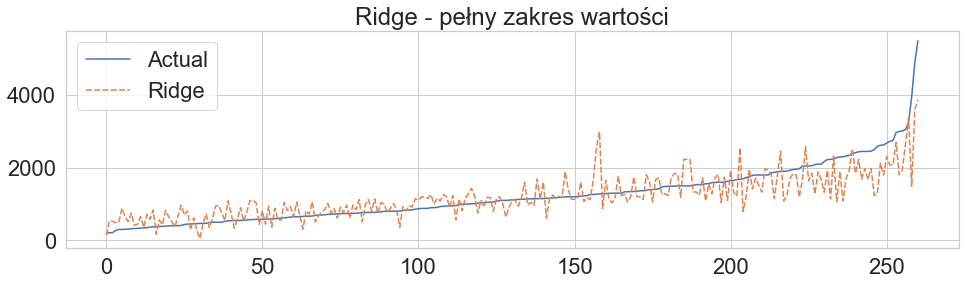

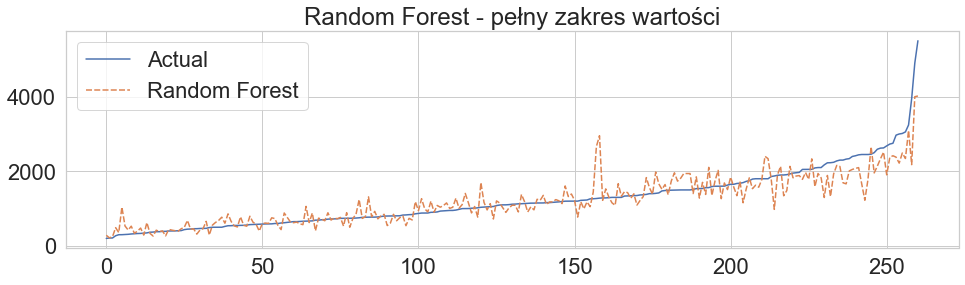

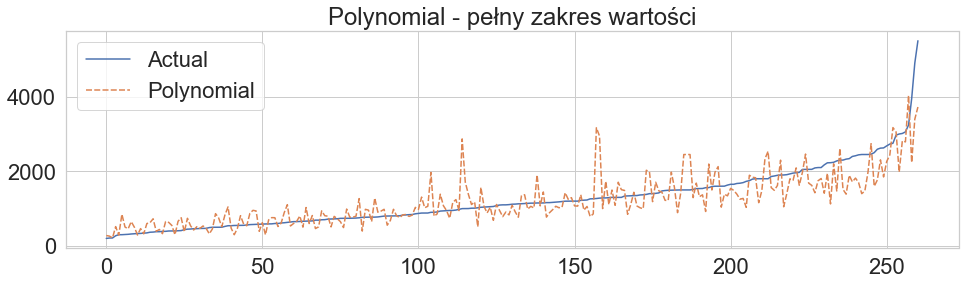

In [168]:
linear_df.columns=['Actual','Linear']
lasso_df=lasso_df.drop(['Actual'], axis = 1)
lasso_df.columns=['Lasso']
ridge_df=ridge_df.drop(['Actual'], axis = 1)
ridge_df.columns=['Ridge']
random_df=random_df.drop(['Actual'], axis = 1)
random_df.columns=['Random Forest']
polynomial_df=polynomial_df.drop(['Actual'], axis = 1)
polynomial_df.columns=['Polynomial']

dfs = [linear_df,lasso_df,ridge_df,random_df,polynomial_df]

dfm = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs )
dfm=dfm.sort_values(by=['Actual'])

dfm=dfm.reset_index()
dfm=dfm.drop(['index'], axis=1)
dfm600=dfm.iloc[:100]

for i in dfm600.columns: 
    if i != 'Actual':
        d = dfm600[["Actual",i]]
        plt.figure(figsize=(16,4))
        sns.set_theme(style="ticks")
        sns.set(font_scale=2)
        sns.lineplot(data=d).set(title=i+'  - do wartości: 600 EUR')
for i in dfm.columns: 
    if i != 'Actual':
        d = dfm[["Actual",i]]
        plt.figure(figsize=(16,4))
        sns.set(font_scale=2, style="whitegrid")
        sns.lineplot(data=d).set(title=i+' - pełny zakres wartości')


        
        

<AxesSubplot:>

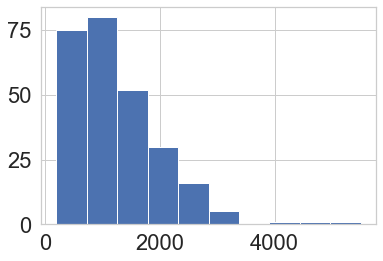

In [169]:
df_actual = dfm["Actual"]
df_actual.hist()

Przeprowadzono porównanie wyników zastosowanych modeli. Najdokładniejszym wg naszych obserwacji jest model: "Random Forest". Należy zwrócić uwagę, iż wszystkie modele regresji uzyskują najlepsze wyniki do wartości sprzętu ok. 600 EUR. Wynika to w dużym stopniu z nadreprezentacji sprzętu w zestawie danych do tej kwoty. Reprezentacja sprzętu powyżej 600 EUR jest znacznie mniejsza i wpływa na dokładność wszystkich modeli.